In [1]:
#Fletcher Newman, April 5th 2024
#fletcht13@tamu.edu, 332000276
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()

In [2]:
#!. DATA PREPERATION AND EXPLORATION
#Import dataset
df = spark.read.csv("On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_1.csv", header=True, sep=",", inferSchema=True)

In [3]:
#Check to see if data type align with dataset
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSeqID: 

In [4]:
#Look at dimentions of dataset
print("Rows:")
df.count()

Rows:


537902

In [5]:
print("Columns: ")
len(df.columns)

Columns: 


110

In [6]:
#Drop rows missing airport names, flight carrier ID's, dellay time (dep and arr), and departure time of day (scheduled)
#Removing the delay time will also remove the canceled flights from the data set (Canceled flights have null delay column)
#These are all catigories that will be used in our data analysis

df = df.na.drop(subset=['Origin', 'Dest', 'Reporting_Airline', 'DepDelay', 'ArrDelay', 'CRSDepTime'])

df.count()

503529

In [7]:
#Confirm there are no duplicate flight entries
df = df.dropDuplicates()
df.count()

503529

In [8]:
#Register the dataframe as temp SQL table
df.createOrReplaceTempView("flights")

In [9]:
#Query 1) Write SQL query to find the top 5 airlines with the most flights
#Group by airline and put their count in descending order to get airline with most flights
query = """
    SELECT Reporting_Airline, COUNT(*) AS FlightCount
    FROM flights
    GROUP BY Reporting_Airline
    ORDER BY FlightCount DESC
    LIMIT 5
"""

# Executing the query
top_airlines = spark.sql(query)

# Showing the result
top_airlines.show()

+-----------------+-----------+
|Reporting_Airline|FlightCount|
+-----------------+-----------+
|               WN|      90859|
|               DL|      66573|
|               AA|      66370|
|               OO|      58651|
|               UA|      42744|
+-----------------+-----------+



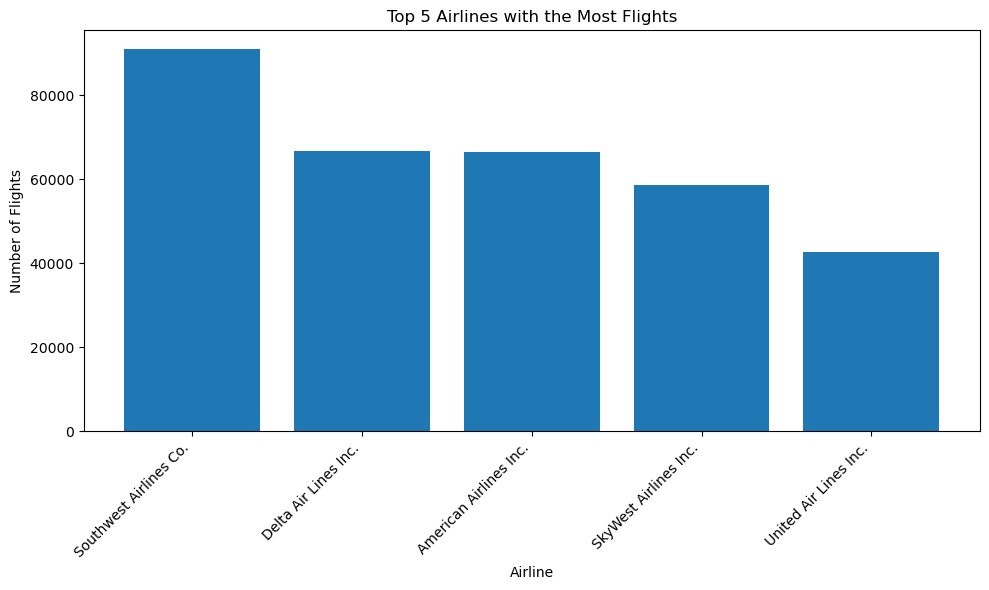

In [10]:
#Create bar graph
#Convert to pandas df
top_airlines_pd = top_airlines.toPandas()

#To make graph more presentable, the 2 letter codes are mapped to the full name of the airline
#The full list will likely come in handy latter
#Codes from https://www.bts.gov/topics/airlines-and-airports/airline-codes
name_map = {'B6' : 'JetBlue Airways', 
            'YV' : 'Mesa Airlines Inc.',
            'F9' : 'Frontier Airlines Inc.',
            'OH' : 'PSA Airlines Inc.',
            'G4' : 'Allegiant Air',
            'QX' : 'Horizon Air',
            'OO' : 'SkyWest Airlines Inc.',
            'NK' : 'Spirit Air Lines',
            'UA' : 'United Air Lines Inc.',
            'HA' : 'Hawaiian Airlines Inc.',
            'AS' : 'Alaska Airlines Inc.',
            'WN' : 'Southwest Airlines Co.',
            'YX' : 'Republic Airline',
            '9E' : 'Endeavor Air Inc.',
            'DL' : 'Delta Air Lines Inc.',
            'AA' : 'American Airlines Inc.',
            'MQ' : 'Envoy Air'}

top_airlines_pd['Reporting_Airline'] = top_airlines_pd['Reporting_Airline'].map(name_map)

#Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_airlines_pd['Reporting_Airline'], top_airlines_pd['FlightCount'])
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.title('Top 5 Airlines with the Most Flights')
plt.xticks(rotation=45, ha='right') #Align labels directly under bars
plt.tight_layout()
plt.show()

In [21]:
#Query 2) Find average flight delay by airline (order highest to lowest)
#Group by airline again and also select the average of the departure delay and the arrival delay
#to account for all kinds of delays
#Order query by average delay 
#Delay times are already in minutes
#Using Dep/ArrDelay instead of Dep/ArrDelay minutes also factors in when airlines depart and arrive early 

query = """
    SELECT Reporting_Airline, AVG(ArrDelay + DepDelay) AS Average_Delay_min
    FROM flights
    GROUP BY Reporting_Airline
    ORDER BY Average_Delay_min DESC
"""

most_delay = spark.sql(query)

most_delay.show()

+-----------------+------------------+
|Reporting_Airline| Average_Delay_min|
+-----------------+------------------+
|               B6| 41.97723009587328|
|               YV|30.085887096774194|
|               F9|26.455685181960646|
|               OH|25.293724674186837|
|               G4|24.393228840125392|
|               QX| 23.05726238724016|
|               OO|22.685120458304205|
|               NK|20.248272603791413|
|               UA|17.761112670784204|
|               HA|16.389893617021276|
|               AS|13.122665088134701|
|               WN|11.267579436269385|
|               YX|10.176639934196997|
|               9E| 10.09348931339158|
|               DL| 7.539107445961576|
|               AA|  6.81136055446738|
|               MQ|3.7098199748802156|
+-----------------+------------------+



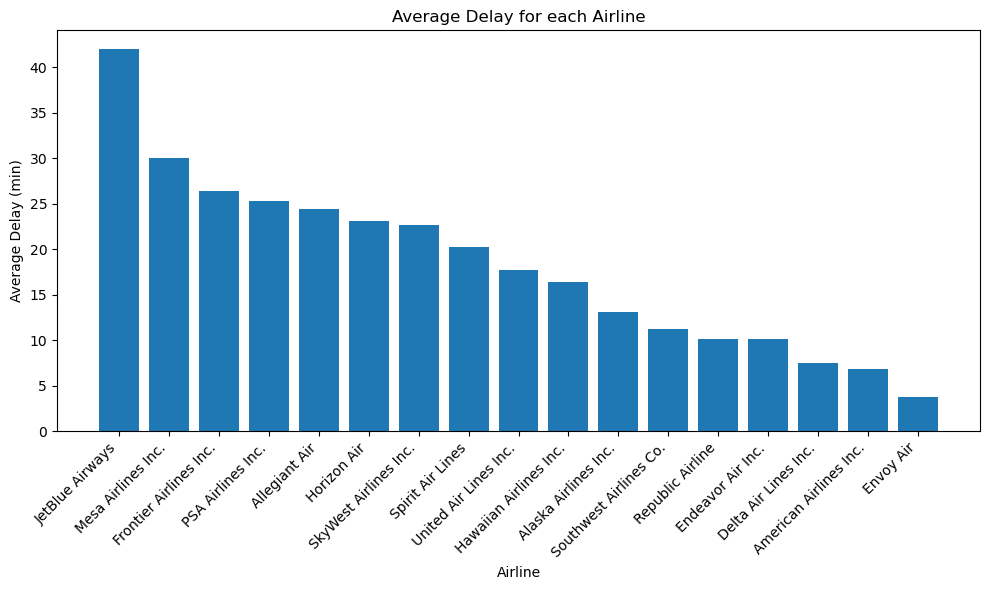

In [12]:
#Create bar graph
#Convert to pandas df
most_delay_pd = most_delay.toPandas()

#Map dataframe again using dict from above
most_delay_pd['Reporting_Airline'] = most_delay_pd['Reporting_Airline'].map(name_map)

#Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(most_delay_pd['Reporting_Airline'], most_delay_pd['Average_Delay_min'])
plt.xlabel('Airline')
plt.ylabel('Average Delay (min)')
plt.title('Average Delay for each Airline')
plt.xticks(rotation=45, ha='right') #Algin right so that labels are correctly aligned 
plt.tight_layout()
plt.show()

In [24]:
#Find number of JetBlue flights
query = """
    SELECT Reporting_Airline, COUNT(*) AS FlightCount
    FROM flights
    GROUP BY Reporting_Airline
    HAVING Reporting_Airline = 'B6'
    ORDER BY FlightCount DESC
    LIMIT 5
"""

# Executing the query
JetBlue = spark.sql(query)

# Showing the result
JetBlue.show()

+-----------------+-----------+
|Reporting_Airline|FlightCount|
+-----------------+-----------+
|               B6|      19192|
+-----------------+-----------+



In [13]:
#Query 3) Identify top 3 busiest airports (arrivals and departures)

#Step 1, create table with only number of depatures 
#(arrivals is 0 so it can be aggrated later)

queryDep = """
    SELECT Origin AS Airport, COUNT(*) AS Departures, 0 AS Arrivals 
    FROM flights 
    GROUP BY Origin
"""

# Executing the query
airport_departures = spark.sql(queryDep)

# Showing the result
airport_departures.show()

+-------+----------+--------+
|Airport|Departures|Arrivals|
+-------+----------+--------+
|    BGM|        31|       0|
|    PSE|        38|       0|
|    DLG|        25|       0|
|    INL|        40|       0|
|    MSY|      3561|       0|
|    GEG|      1386|       0|
|    DRT|        59|       0|
|    SNA|      3496|       0|
|    BUR|      2281|       0|
|    GTF|       165|       0|
|    GRB|       308|       0|
|    FOD|        46|       0|
|    IDA|       255|       0|
|    GRR|      1243|       0|
|    LWB|        21|       0|
|    PVU|       100|       0|
|    JLN|        54|       0|
|    PSG|        54|       0|
|    EUG|       691|       0|
|    ATY|         2|       0|
+-------+----------+--------+
only showing top 20 rows



In [14]:
#Step one, create table with only number of arrivals 
#(departures is 0 so it can be aggrated later)

queryArr = """
    SELECT Dest AS Airport, 0 AS Departures, COUNT(*) as Arrivals
    FROM flights
    GROUP BY Dest
"""

airport_arrivals = spark.sql(queryArr)

airport_arrivals.show()

+-------+----------+--------+
|Airport|Departures|Arrivals|
+-------+----------+--------+
|    BGM|         0|      31|
|    PSE|         0|      38|
|    INL|         0|      40|
|    MSY|         0|    3560|
|    GEG|         0|    1387|
|    DRT|         0|      60|
|    BUR|         0|    2291|
|    SNA|         0|    3507|
|    GTF|         0|     170|
|    GRB|         0|     313|
|    FOD|         0|      47|
|    IDA|         0|     253|
|    GRR|         0|    1248|
|    LWB|         0|      21|
|    PVU|         0|     100|
|    JLN|         0|      56|
|    PSG|         0|      56|
|    EUG|         0|     690|
|    MYR|         0|     671|
|    PVD|         0|    1012|
+-------+----------+--------+
only showing top 20 rows



In [15]:
#Step 3, create a query from joining both arrival and departure count queries and taking their sumation
#Order by total traffic descending and limit the query to 3 to get the top 3 airports
query = f"""
    SELECT Airport, SUM(Departures + Arrivals) AS totalTraffic
    FROM (
        {queryDep}
        UNION
        {queryArr}
    ) AS traffic
    GROUP BY Airport
    ORDER BY totalTraffic DESC
    LIMIT 3
"""

top_airports = spark.sql(query)
top_airports.show()

+-------+------------+
|Airport|totalTraffic|
+-------+------------+
|    ATL|       48863|
|    DFW|       44056|
|    DEN|       38708|
+-------+------------+



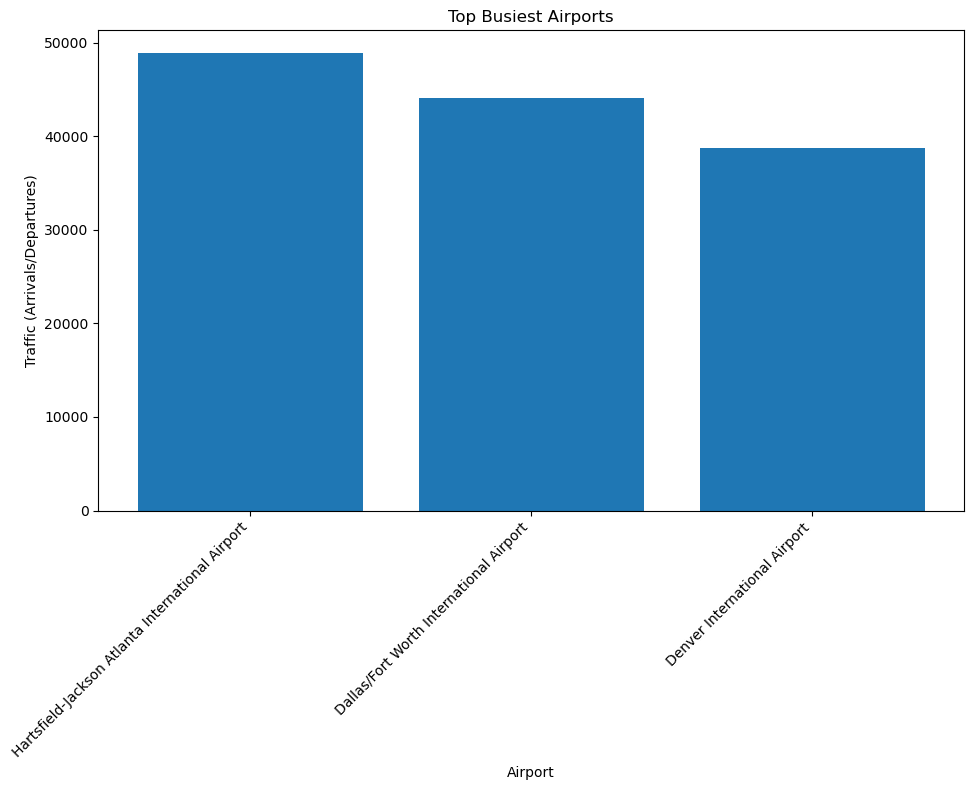

In [26]:
#Create bar graph
#Convert to pandas df
top_airports_pd = top_airports.toPandas()

#Map to Airport names
airport_map = {'ATL' : 'Hartsfield-Jackson Atlanta International Airport',
               'DFW' : 'Dallas/Fort Worth International Airport',
               'DEN' : 'Denver International Airport'}

#Map dataframe again using dict from above
top_airports_pd['Airport'] = top_airports_pd['Airport'].map(airport_map)

#Plot bar graph
plt.figure(figsize=(10, 8))
plt.bar(top_airports_pd['Airport'], top_airports_pd['totalTraffic'])
plt.xlabel('Airport')
plt.ylabel('Traffic (Arrivals/Departures)')
plt.title('Top Busiest Airports')
plt.xticks(rotation=45, ha='right') #Algin right so that labels are correctly aligned 
plt.tight_layout()
plt.show()

In [28]:
#Find in terms of city

queryDepCity = """
    SELECT OriginCityName AS City, COUNT(*) AS Departures, 0 AS Arrivals 
    FROM flights 
    GROUP BY City
"""

queryArrCity = """
    SELECT DestCityName AS City, 0 AS Departures, COUNT(*) as Arrivals
    FROM flights
    GROUP BY City
"""

queryCity = f"""
    SELECT City, SUM(Departures + Arrivals) AS totalTraffic
    FROM (
        {queryDepCity}
        UNION
        {queryArrCity}
    ) AS traffic
    GROUP BY City
    ORDER BY totalTraffic DESC
    LIMIT 3
"""

top_cities = spark.sql(queryCity)
top_cities.show()

+------------+------------+
|        City|totalTraffic|
+------------+------------+
| Atlanta, GA|       48863|
| Chicago, IL|       46994|
|New York, NY|       45020|
+------------+------------+



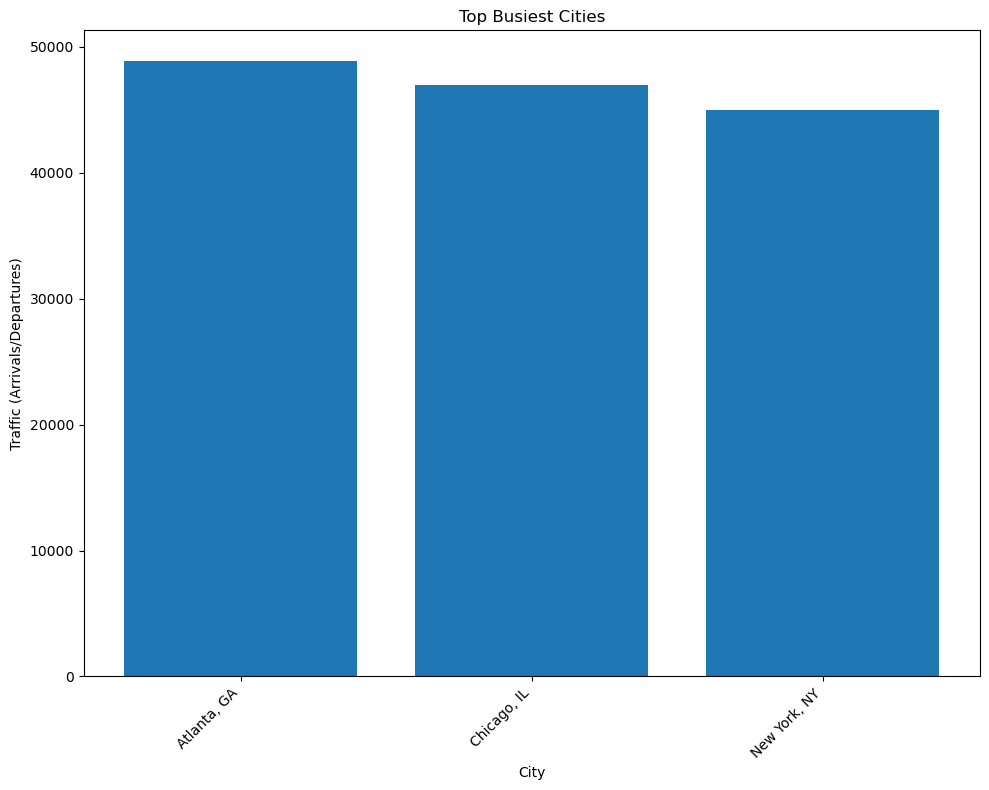

In [30]:
#Create bar graph
#Convert to pandas df
top_cities_pd = top_cities.toPandas()

#Plot bar graph
plt.figure(figsize=(10, 8))
plt.bar(top_cities_pd['City'], top_cities_pd['totalTraffic'])
plt.xlabel('City')
plt.ylabel('Traffic (Arrivals/Departures)')
plt.title('Top Busiest Cities')
plt.xticks(rotation=45, ha='right') #Algin right so that labels are correctly aligned 
plt.tight_layout()
plt.show()

In [29]:
#Query 4) Find average time of delay for each time of day

#This query will use the CASE clause to put time ranges into catigories (24 hr time is used as an integer)
#Canclled flights are left out of this dataset 
#The average of each time periods delays (departure and arrival) is selected to measure delays relitive to other periods
#Flights are grouped by the time period they were filtered into and ordered from highest time of delay to lowest
query = """
    SELECT
        CASE 
            WHEN (CRSDepTime BETWEEN 601 AND 1200) AND (Cancelled = 0) THEN 'Morning'
            WHEN (CRSDepTime BETWEEN 1201 AND 1800) AND (Cancelled = 0) THEN 'Afternoon'
            WHEN (CRSDepTime BETWEEN 1801 AND 2400) AND (Cancelled = 0) THEN 'Evening'
            WHEN (CRSDepTime BETWEEN 0 AND 600) AND (Cancelled = 0) THEN 'Night'
            ELSE 'Unknown'
        END AS TimePeriod,
        AVG(DepDelay + ArrDelay) AS AvgDelay
    FROM flights
    GROUP BY TimePeriod
    ORDER BY AvgDelay DESC
"""

# Executing the query
avg_delay_time_periods = spark.sql(query)

# Showing the result
avg_delay_time_periods.show()

+----------+------------------+
|TimePeriod|          AvgDelay|
+----------+------------------+
|   Evening|22.965202306718552|
| Afternoon|17.237314086922648|
|   Morning| 8.749632061887988|
|     Night| 8.086150490730644|
+----------+------------------+



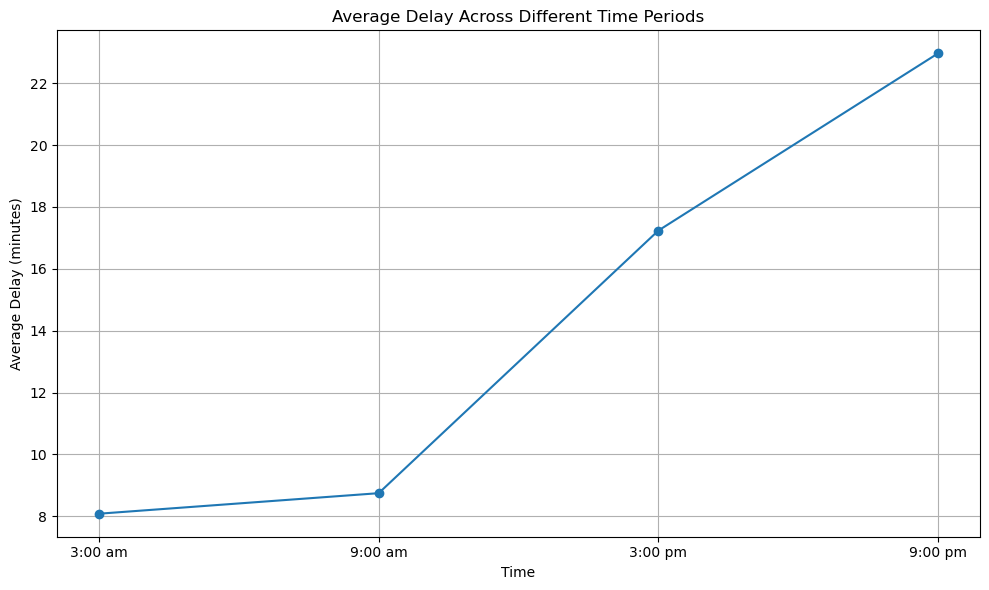

In [18]:
#Convert to pandas df
avg_delay_time_periods_pd = avg_delay_time_periods.toPandas()

#Map time of day to specific time (Average of time period)
time_map = {'Morning' : '9:00 am',
            'Afternoon' : '3:00 pm',
            'Evening' : '9:00 pm',
            'Night' : '3:00 am'}

avg_delay_time_periods_pd['TimePeriod'] = avg_delay_time_periods_pd['TimePeriod'].map(time_map)

#Plot line graph
plt.figure(figsize=(10, 6))
plt.plot(avg_delay_time_periods_pd['TimePeriod'], avg_delay_time_periods_pd['AvgDelay'], marker='o')
plt.xlabel('Time')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Delay Across Different Time Periods')
plt.grid(True)  # Add# grid for better readability
plt.gca().invert_xaxis()  # Invert x-axis so 3 am comes first and 9 pm comes last
plt.tight_layout()
plt.show()

In [42]:
#Query 5) Find top 5 routes with highest average delay. 

#This query selects the origin and destination airports and groups the rows together by both origin and dest
#This gets the full flight routes from takeoff to landing
#The average of the total delay (arrival and departure) is also selected and ordered by (descending) to find 
#which route has the highest average delay
#Count is restricted to only include routes with at least 100 departures. This was done so that outliers would not affect 
#the data as much. The decision to make 100 the threshold was based off the data observed in query 3. It was determined 
#that 100 is a good value that excludes the outlier routes (one offs that could of had major delays) and still includes
#signifigant routes 

query = """
    SELECT Origin AS Departing_Airport, Dest AS Destination_Airport, AVG(ArrDelay + DepDelay) as Average_Delay, COUNT(*) AS Flight_Count
    FROM flights 
    WHERE (Cancelled = 0) 
    GROUP BY Origin, Dest
    HAVING Flight_Count > 100
    ORDER BY Average_Delay DESC
    LIMIT 5
"""

flight_path_delays = spark.sql(query)
flight_path_delays.show()

+-----------------+-------------------+-----------------+------------+
|Departing_Airport|Destination_Airport|    Average_Delay|Flight_Count|
+-----------------+-------------------+-----------------+------------+
|              RSW|                BOS|87.27922077922078|         154|
|              DCA|                ORF|72.29807692307692|         104|
|              DEN|                BOS|71.86705202312139|         173|
|              DRO|                DEN|69.94117647058823|         102|
|              PDX|                DFW|        68.328125|         128|
+-----------------+-------------------+-----------------+------------+



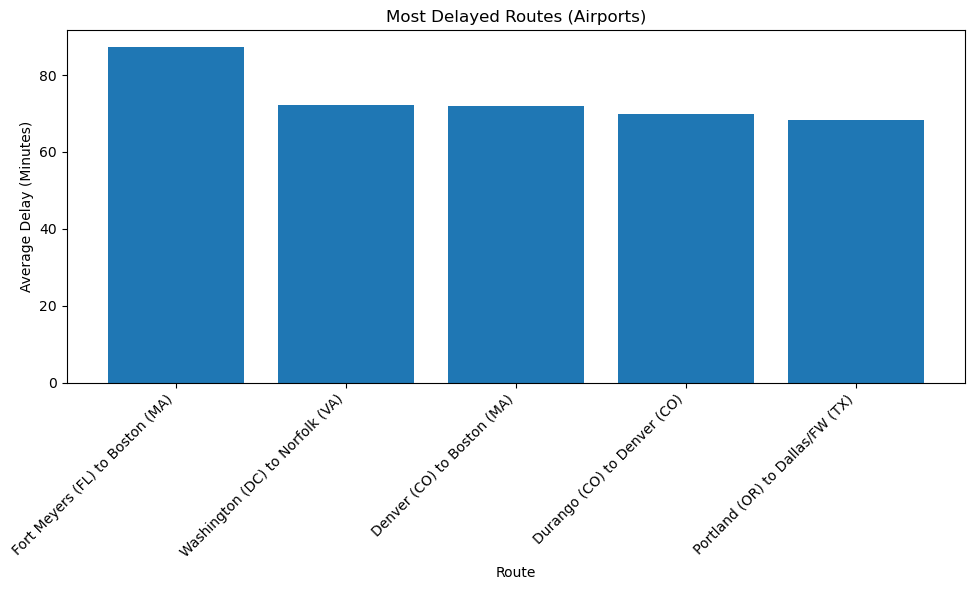

In [43]:
#Create bar graph
#Convert to pandas
flight_path_delays_pd = flight_path_delays.toPandas()

#Map to routes (specific for this query dataframe)
route_map = {'RSW' : 'Fort Meyers (FL) to Boston (MA)',
             'DCA' : 'Washington (DC) to Norfolk (VA)',
             'DEN' : 'Denver (CO) to Boston (MA)',
             'DRO' : 'Durango (CO) to Denver (CO)',
             'PDX' : 'Portland (OR) to Dallas/FW (TX)'}

#Map dataframe again using dict from above
flight_path_delays_pd['Departing_Airport'] = flight_path_delays_pd['Departing_Airport'].map(route_map)

#Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(flight_path_delays_pd['Departing_Airport'], flight_path_delays_pd['Average_Delay'])
plt.xlabel('Route')
plt.ylabel('Average Delay (Minutes)')
plt.title('Most Delayed Routes (Airports)')
plt.xticks(rotation=45, ha='right') #Algin right so that labels are correctly aligned 
plt.tight_layout()
plt.show()

In [44]:
#Now do the same but with cities

query = """
    SELECT OriginCityName AS Departing_City, DestCityName AS Destination_City, AVG(ArrDelay + DepDelay) as Average_Delay, COUNT(*) AS Flight_Count
    FROM flights 
    WHERE (Cancelled = 0) 
    GROUP BY OriginCityName, DestCityName
    HAVING Flight_Count > 100
    ORDER BY Average_Delay DESC
    LIMIT 5
"""

flight_path_delays_cities = spark.sql(query)
flight_path_delays_cities.show()

+--------------+--------------------+-----------------+------------+
|Departing_City|    Destination_City|    Average_Delay|Flight_Count|
+--------------+--------------------+-----------------+------------+
|Fort Myers, FL|          Boston, MA|87.27922077922078|         154|
|  Syracuse, NY|      Washington, DC|73.91346153846153|         104|
|    Denver, CO|          Boston, MA|71.86705202312139|         173|
|   Durango, CO|          Denver, CO|69.94117647058823|         102|
|  Portland, OR|Dallas/Fort Worth...|        68.328125|         128|
+--------------+--------------------+-----------------+------------+



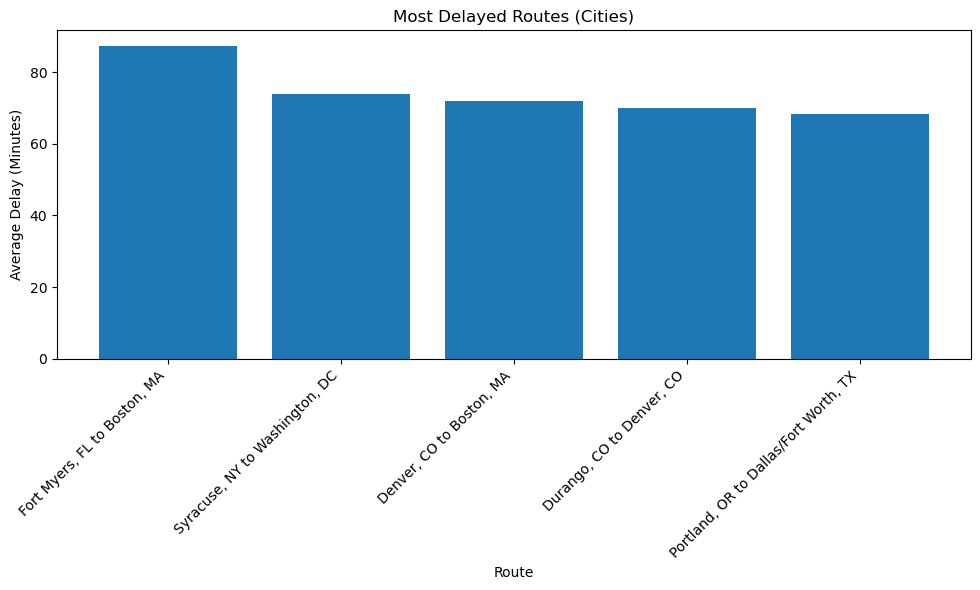

In [45]:
#Create bar graph
#Convert to pandas
flight_path_delays_cities_pd = flight_path_delays_cities.toPandas()

# #Map to routes (specific for this query dataframe)
for i in range(len(flight_path_delays_cities_pd)):
    flight_path_delays_cities_pd.at[i, 'Departing_City'] = flight_path_delays_cities_pd.at[i, 'Departing_City'] + ' to ' + flight_path_delays_cities_pd.at[i, 'Destination_City']



#Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(flight_path_delays_cities_pd['Departing_City'], flight_path_delays_cities_pd['Average_Delay'])
plt.xlabel('Route')
plt.ylabel('Average Delay (Minutes)')
plt.title('Most Delayed Routes (Cities)')
plt.xticks(rotation=45, ha='right') #Algin right so that labels are correctly aligned 
plt.tight_layout()
plt.show()